<a href="https://colab.research.google.com/github/ekrell/shap_multiband/blob/main/PartitionShap_EuroSAT_RGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `PartitionShap`: EuroSAT (RGB) channel-wise demo

**Purpose:** This notebook compares the default implementation of `PartitionShap` to [CBI's fork](https://github.com/conrad-blucher-institute/shap) that implement's channel-wise explanations. 
That is, the default paritions images by splitting the rows and columns. Only at the pixel-level does it split across the channels/bands. For 3D inputs, it may be of interest to explain the contribution of bands on superpixel regions. 
The fork introduces the option to split first by channels, then by superpixels. 
This notebook also demonstrates that the choice of `masker` (how to represent features that are "not present") has a significant affect on the explanation. 

**Data:**
[EuroSAT RGB](https://arxiv.org/abs/1709.00029)

**Notebooks in series**
- `PartitionShap`: ImageNet (RGB) channel-wise demo
- `PartitionShap`: EuroSAT (RGB) channel-wise demo
- `PartitionShap`: EuroSAT (13-band) channel-wise demo

# Setup environment

In [1]:
# Options
TRAIN = False # Load trained model instead
useCBIweights = True # Download Conrad Blutcher Institute's pretrained model
path_model = "eurosat_landuse_RGB.pt"

if useCBIweights:
  !gdown https://drive.google.com/uc?id=14BYvrjem4dbmkmibmmSD2cDq2ZvStfVG

Downloading...
From: https://drive.google.com/uc?id=14BYvrjem4dbmkmibmmSD2cDq2ZvStfVG
To: /content/eurosat_landuse_RGB.pt
44.8MB [00:00, 142MB/s] 


In [2]:
# Install CBI's SHAP fork
!pip install git+https://github.com/conrad-blucher-institute/shap.git
# Install torchsat
!pip install develop git+https://github.com/sshuair/torchsat.git

  Cloning https://github.com/conrad-blucher-institute/shap.git to /tmp/pip-req-build-ygkc_v23
  Running command git clone -q https://github.com/conrad-blucher-institute/shap.git /tmp/pip-req-build-ygkc_v23
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=3068881 sha256=53af8243d27346c0495662da0deb72d572f69d33930f9a0e75fbddd21feece0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-58rg6zqd/wheels/2a/df/e0/7c6260159a5c39dd54cb2dd8787410c3e14d9d9cc5345f1eb4
Successfully built shap
  Cloning https://github.com/sshuair/torchsat.git to /tmp/pip-req-build-1p6v5346
  Running command git clone -q https://github.com/sshuair/torchsat.git /tmp/pip-req-build-1p6v5346
     |████████████████████████████████| 19.1MB 161kB/s 
     |████████████████████████████████| 1.0MB 49.3MB/s 
     |████████████████████████████████| 6.5MB 32.6MB/s 
     |████████████████████████████████| 15.3MB 215kB/s 
  Created wheel for develop: filename=develop-0.1.4-cp37-none-any.whl size=27753

In [3]:
# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import DataLoader
# Torchsat
import torchsat.transforms.functional as F
import torchsat.transforms.transforms_cls as T_cls
from torchsat.transforms import transforms_cls
import torchsat.datasets as datasets
from torchsat.datasets.folder import DatasetFolder
from torchsat.datasets.folder import ImageFolder
from torchsat.datasets.utils import tifffile_loader
import torchsat.models as models
from torchsat.models.classification.resnet import resnet18, resnet34, resnet50, resnet101, resnet152, resnext50_32x4d, resnext101_32x8d, wide_resnet50_2, wide_resnet101_2
# Sci
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from PIL import Image
# General
import matplotlib.pyplot as plt
import copy
from collections import namedtuple
import os
import random
import shutil
import time
from pathlib import Path
import math
# Shap
import shap

# Load data
EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification

    Helber, Patrick, et al. "Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification." IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing 12.7 (2019): 2217-2226.

This uses a reduced dataset: only RGB of the original 13 bands

- Images: 27000
- Size: 64x64 (13 bands)
- Classes:
  - AnnualCrop (3000)
  - Forest (3000)
  - HerbaceousVegetation (3000)
  - Highway (2500)
  - Industrial (2500)
  - Pasture (2000)
  - PermanentCrop (2500)
  - Residential (3000)
  - River (2500)
  - SeaLake (3000) 
- Bands:
  - B02: Blue
  - B03: Green
  - B04: Red


In [4]:
# Download data
# get the train data
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
!unzip -q EuroSAT.zip
# split into train and val datasets.
!mkdir EuroSAT & mkdir EuroSAT/train & mkdir EuroSAT/val
!rsync -rP --remove-source-files --include='*2.jpg' --include="*/" --exclude='*' ./2750/* ./EuroSAT/val/
!mv ./2750/* ./EuroSAT/train

Streaming output truncated to the last 5000 lines.
          3,667 100%   46.51kB/s    0:00:00 (xfr#205, ir-chk=1195/1410)
AnnualCrop/AnnualCrop_2832.jpg
          2,970 100%   37.67kB/s    0:00:00 (xfr#206, ir-chk=1194/1410)
AnnualCrop/AnnualCrop_2842.jpg
          3,643 100%   45.61kB/s    0:00:00 (xfr#207, ir-chk=1193/1410)
AnnualCrop/AnnualCrop_2852.jpg
          4,141 100%   51.85kB/s    0:00:00 (xfr#208, ir-chk=1192/1410)
AnnualCrop/AnnualCrop_2862.jpg
          3,465 100%   43.38kB/s    0:00:00 (xfr#209, ir-chk=1191/1410)
AnnualCrop/AnnualCrop_2872.jpg
          3,485 100%   43.63kB/s    0:00:00 (xfr#210, ir-chk=1190/1410)
AnnualCrop/AnnualCrop_2882.jpg
          4,052 100%   50.73kB/s    0:00:00 (xfr#211, ir-chk=1189/1410)
AnnualCrop/AnnualCrop_2892.jpg
          3,444 100%   43.12kB/s    0:00:00 (xfr#212, ir-chk=1188/1410)
AnnualCrop/AnnualCrop_2902.jpg
          2,964 100%   37.11kB/s    0:00:00 (xfr#213, ir-chk=1187/1410)
AnnualCrop/AnnualCrop_2912.jpg
          3,356 100%  

In [5]:
# Define transformers
train_transform = T_cls.Compose([
    T_cls.RandomHorizontalFlip(),
    T_cls.RandomVerticalFlip(),
    T_cls.ToTensor(),
    T_cls.Normalize(),
])
val_transform = T_cls.Compose([
    T_cls.ToTensor(),
    T_cls.Normalize(),
])

# Load data
trainData = ImageFolder("EuroSAT/train", train_transform)
valData = ImageFolder("EuroSAT/val", val_transform)
classes = trainData.classes
n_classes = len(classes)

AnnualCrop_7.jpg
Forest_10.jpg
HerbaceousVegetation_10.jpg
Highway_5.jpg
Industrial_7.jpg
Pasture_6.jpg
PermanentCrop_4.jpg
Residential_8.jpg
River_4.jpg
SeaLake_5.jpg


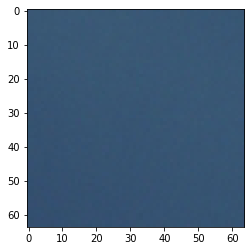

In [6]:
%matplotlib inline

class_to_idx = {
        'AnnualCrop': 0,
        'Forest': 1,
        'HerbaceousVegetation': 2,
        'Highway': 3,
        'Industrial': 4,
        'Pasture': 5,
        'PermanentCrop': 6,
        'Residential': 7,
        'River': 8,
        'SeaLake': 9,
    }
idx_to_class = {v: k for k, v in class_to_idx.items()}

images = [os.path.join('EuroSAT/train', x, x+'_'+str(random.randint(3,10))+'.jpg') for x in class_to_idx.keys()]

for item in images:
  print(os.path.basename(item))
  img = Image.open(item)
  plt.imshow(img)

# Train model

In [7]:
# Params
printFreq = 100
# Hardware
device = torch.device('cuda')
# Batch size
batchSize = 64
# Transfer learning?
usePretrained = True
# Initial learning rate
learningRate = 0.1
# epochs
n_epochs = 100

In [8]:
# Data loaders
train_loader = DataLoader(trainData, batch_size=batchSize, shuffle=True)
val_loader   = DataLoader(valData,   batch_size=batchSize, shuffle=True)

In [9]:
# Load model
torch.backends.cudnn.benchmark = True
model = resnet50(in_channels=3, num_classes=n_classes, pretrained=usePretrained)
model.to(device)

# Define learning components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learningRate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [10]:
def train_one_epoch(model, criterion, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    for idx, (image, target) in enumerate(data_loader):
        image, target = image.to(device), target.to(device)
        output = model(image)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % print_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(image), len(data_loader.dataset), 100. * idx / len(data_loader), loss.item()))

In [11]:
def evaluate(epoch, model, criterion, data_loader, device):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for idx, (image, target) in enumerate(data_loader):
            image = image.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(image)
            loss += criterion(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

        loss /= len(data_loader.dataset)/data_loader.batch_size

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))

In [12]:
# Save model
if TRAIN:
  torch.save(model, path_model)

# Load model
model = torch.load(path_model)
model.eval();

# Evaluate model

In [13]:
def getPredictions(model, data_loader, device, print_freq):
    model.eval()
    trueLabels = []
    predLabels = []
    # model.to(device, non_blocking=True, type=torch.double)
    model = model.to("cpu", dtype=torch.double)
    with torch.no_grad():
        for idx, (image, target) in enumerate(data_loader):
            # image = image.to(device, non_blocking=True)
            image = image.to("cpu", dtype=torch.double)
            # target = target.to(device, non_blocking=True)
            output = model(image)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            trueLabels.append(target)
            predLabels.append(pred)
            if idx % print_freq == 0:
              print("processed: {}".format(idx))
    return trueLabels, predLabels

In [14]:
# Get validation results
trueLabels, predLabels = getPredictions(model, val_loader, device, printFreq)

processed: 0


In [15]:
trueLabels = [item.item() for sublist in trueLabels for item in sublist]
predLabels = [item.item() for sublist in predLabels for item in sublist]

In [16]:
def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

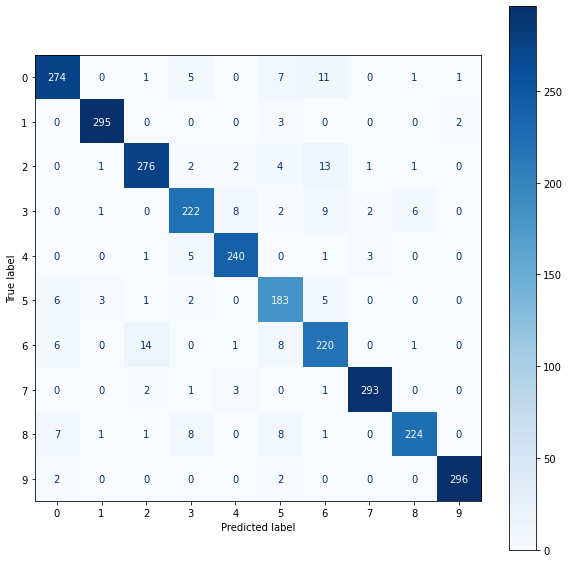

In [17]:
plot_confusion_matrix(trueLabels, predLabels)

## Default `PartitionShap`

Partition mode 0: channels (zaxis) split last

With 500 evaluations, will never even use channel-wise masks

In [18]:
def m(X):
  # Go from (batch size, height, width, channels)
  #      to (batch size, channels, height, width)
  X = np.moveaxis(X, (0, 1, 2, 3), (0, 2, 3, 1))

  # Numpy to pytorch tensor
  # image = val_transform(X)
  image = torch.from_numpy(X)  #.ToTensor()

  # Prepare input, model for evaluation
  image = image.to("cpu", dtype=torch.double)
  
  # Evaluate model
  res = model(image)
  return res.detach().numpy()

In [19]:
# Get batch of images, labels
batch = next(iter(val_loader))
X = batch[0]
y = batch[1]

# Convert from tensor (from pytorch) to generic numpy (for shap)
Xshap = X.numpy()
# Go from (batch size, channels, height, width)
#      to (batch size, height, width, channels)
Xshap = np.moveaxis(Xshap, (0, 1, 2, 3), (0, 3, 1, 2))

In [34]:
def explain_singleband(masker):
  explainer = shap.Explainer(m, masker, output_names=classes)

  # Explain batch (calculate shap values)
  shap_values = explainer(Xshap[4:6], max_evals=500, batch_size=batchSize, outputs=shap.Explanation.argsort.flip[:4])

  toplot = range(4,6)
  Xplot = np.array([(Xshap[t] - np.min(Xshap[t]))/np.ptp(Xshap[t]) for t in toplot])
  shap.image_plot(shap_values, pixel_values=Xplot, )

In [31]:
# define maskers
# See masker documentation for details: 
#    https://shap.readthedocs.io/en/latest/generated/shap.maskers.Image.html#shap.maskers.Image
masker_inpaint_telea = shap.maskers.Image("inpaint_telea", Xshap[0].shape)
masker_inpaint_ns    = shap.maskers.Image("inpaint_ns", Xshap[0].shape)
masker_blur_3x3      = shap.maskers.Image("blur(3, 3)", Xshap[0].shape)
masker_blur_10x10    = shap.maskers.Image("blur(10, 10)", Xshap[0].shape)
masker_blur_100x100  = shap.maskers.Image("blur(100, 100)", Xshap[0].shape)
masker_uniform_black = shap.maskers.Image(np.zeros_like(Xshap[0]), Xshap[0].shape)
masker_uniform_gray  = shap.maskers.Image(np.zeros_like(Xshap[0]) + 128, Xshap[0].shape)
masker_uniform_white = shap.maskers.Image(np.zeros_like(Xshap[0]) + 255, Xshap[0].shape)

In [ ]:
# Masker: inpaint telea
#explain_singleband(masker_inpaint_telea)

# Does not support 12-bit images: 
# "(-210:Unsupported format or combination of formats) 
# 8-bit, 16-bit unsigned or 32-bit float 1-channel and 
# 8-bit 3-channel input/output images are supported in function 'icvInpaint'"

In [ ]:
# Masker: inpaint NS
# explain_singleband(masker_inpaint_ns)

# Does not support 12-bit images: 
# "(-210:Unsupported format or combination of formats) 
# 8-bit, 16-bit unsigned or 32-bit float 1-channel and 
# 8-bit 3-channel input/output images are supported in function 'icvInpaint'"

Partition explainer: 3it [00:13,  4.42s/it]               

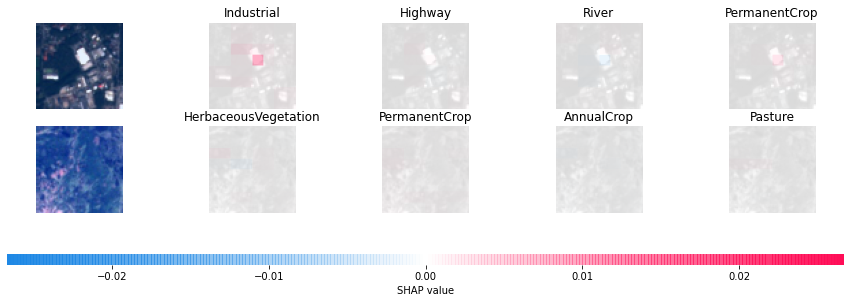

In [38]:
# Masker 3x3 blur kernel
explain_singleband(masker_blur_3x3)

Partition explainer: 3it [00:13,  4.42s/it]               

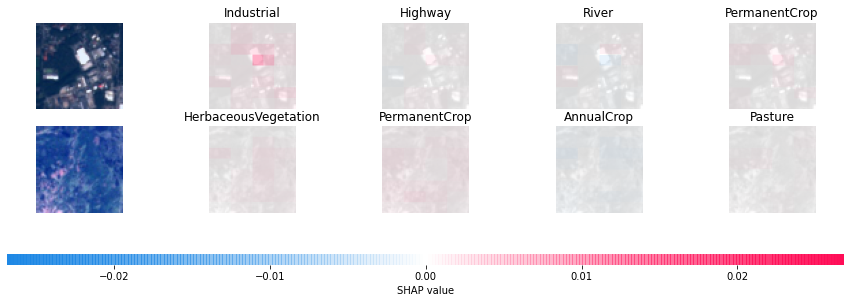

In [39]:
# Masker 10x10 blur kernel
explain_singleband(masker_blur_10x10)

Partition explainer: 3it [00:13,  4.37s/it]               

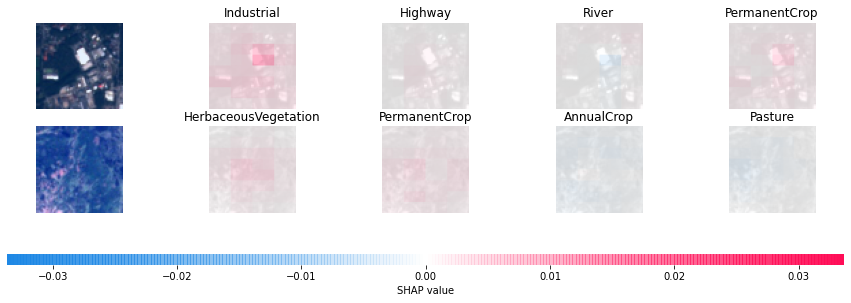

In [40]:
# Masker: 100x100 blur kernel
explain_singleband(masker_blur_100x100)

Partition explainer: 3it [00:12,  4.20s/it]               

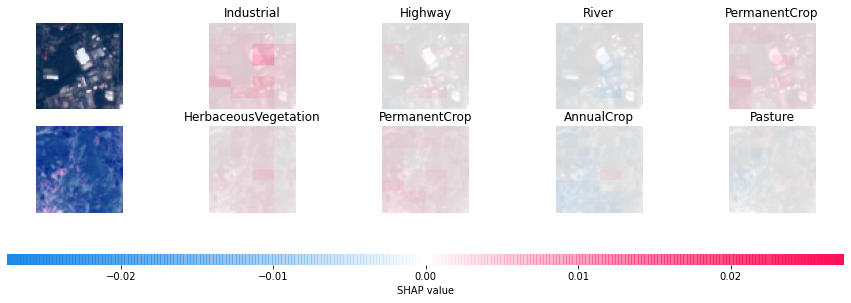

In [41]:
# Masker: black image
explain_singleband(masker_uniform_black)

Partition explainer: 3it [00:12,  4.22s/it]               

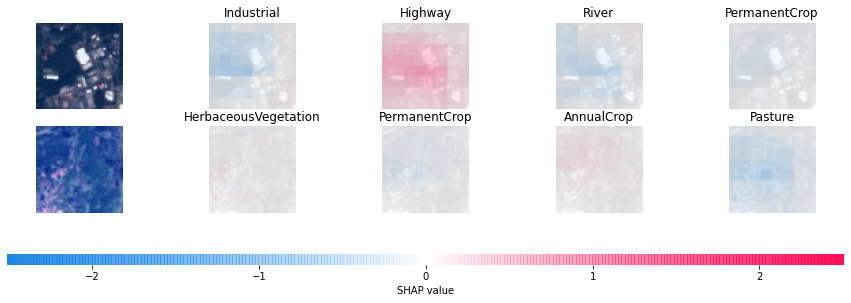

In [42]:
# Masker: gray image
explain_singleband(masker_uniform_gray)

Partition explainer: 3it [00:12,  4.19s/it]               

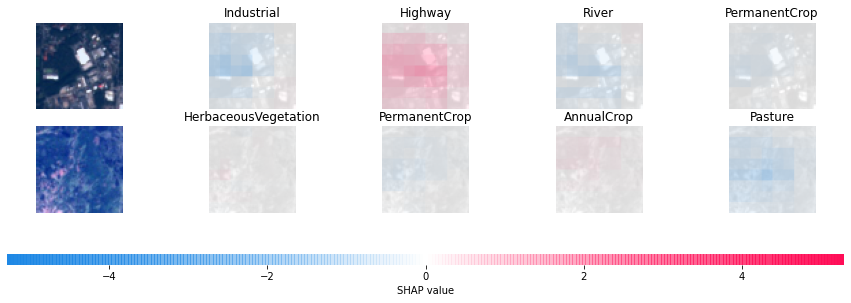

In [43]:
# Masker: white image
explain_singleband(masker_uniform_white)

## Channel-wise `PartitionShap`

Partition mode 1: channels (zaxis) split first

Break into RGB bands

In [51]:
def explain_multiband(masker):
  explainer = shap.Explainer(m, masker, output_names=classes)

  # Explain batch (calculate shap values)
  shap_values = explainer(Xshap[4:6], max_evals=1500, batch_size=batchSize, outputs=shap.Explanation.argsort.flip[:4])

  toplot = range(4,6)
  Xplot = np.array([(Xshap[t] - np.min(Xshap[t]))/np.ptp(Xshap[t]) for t in toplot])
  shap.image_plot(shap_values, pixel_values=Xplot, plotchannels=[0, 1, 2], hspace=0.3)

  return shap_values

In [45]:
def save_shap(shap_values, filename, Class=0):
  # Save selected SHAP values
  image0 = shap_values[0, :, :, :, Class].values
  image1 = shap_values[1, :, :, :, Class].values
  np.savez_compressed(filename, array_0=image0, array_1=image1)

In [60]:
masker_inpaint_telea = shap.maskers.Image("inpaint_telea", Xshap[0].shape, partition_scheme=1)
masker_inpaint_ns    = shap.maskers.Image("inpaint_ns", Xshap[0].shape, partition_scheme=1)
masker_blur_3x3      = shap.maskers.Image("blur(3, 3)", Xshap[0].shape, partition_scheme=1)
masker_blur_10x10    = shap.maskers.Image("blur(10, 10)", Xshap[0].shape, partition_scheme=1)
masker_blur_100x100  = shap.maskers.Image("blur(100, 100)", Xshap[0].shape, partition_scheme=1)
masker_uniform_black = shap.maskers.Image(np.zeros_like(Xshap[0]), Xshap[0].shape, partition_scheme=1)
masker_uniform_gray  = shap.maskers.Image(np.zeros_like(Xshap[0]) + 128, Xshap[0].shape, partition_scheme=1)
masker_uniform_white = shap.maskers.Image(np.zeros_like(Xshap[0]) + 255, Xshap[0].shape, partition_scheme=1)

In [61]:
# Masker: inpaint telea
# shap_values = explain_multiband(masker_inpaint_telea)
# save_shap(shap_values, "shap_imagenet_rgb_multiband_inpaint-telea.npz")

# Does not support 12-bit images: 
# "(-210:Unsupported format or combination of formats) 
# 8-bit, 16-bit unsigned or 32-bit float 1-channel and 
# 8-bit 3-channel input/output images are supported in function 'icvInpaint'"

In [62]:
# Masker: inpaint NS
# shap_values = explain_multiband(masker_inpaint_ns)
# save_shap(shap_values, "shap_imagenet_rgb_multiband_inpaint-ns.npz")

# Does not support 12-bit images: 
# "(-210:Unsupported format or combination of formats) 
# 8-bit, 16-bit unsigned or 32-bit float 1-channel and 
# 8-bit 3-channel input/output images are supported in function 'icvInpaint'"

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [00:33, 11.24s/it]


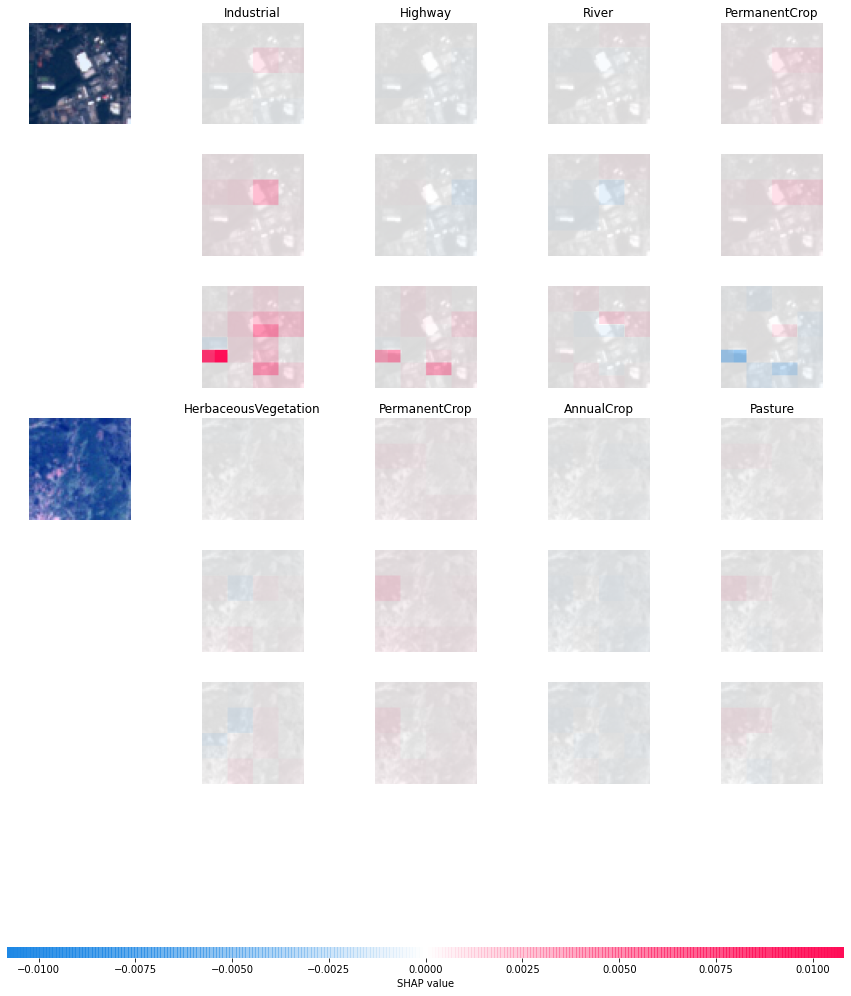

In [63]:
# Masker 3x3 blur kernel
shap_values = explain_multiband(masker_blur_3x3)
save_shap(shap_values, "shap_eurosat_rgb_multiband_blur-3x3.npz")

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [00:33, 11.22s/it]


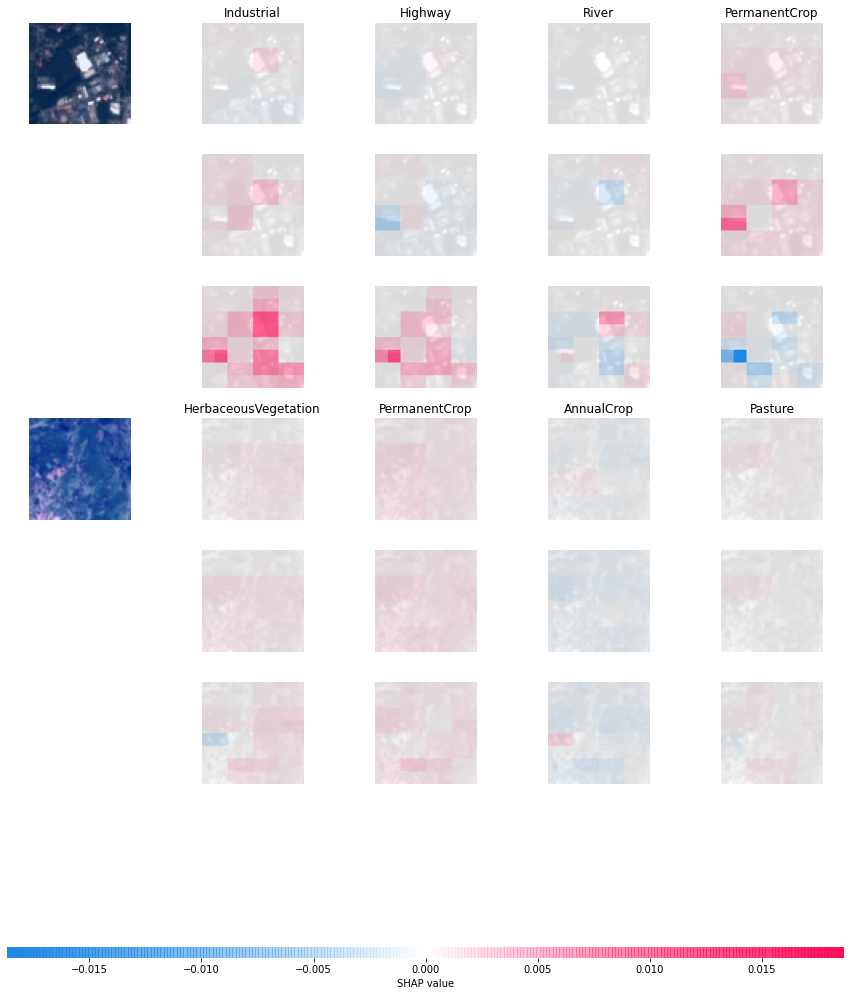

In [64]:
# Masker 10x10 blur kernel
shap_values = explain_multiband(masker_blur_10x10)
save_shap(shap_values, "shap_eurosat_rgb_multiband_blur-10x10.npz")

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [00:33, 11.26s/it]


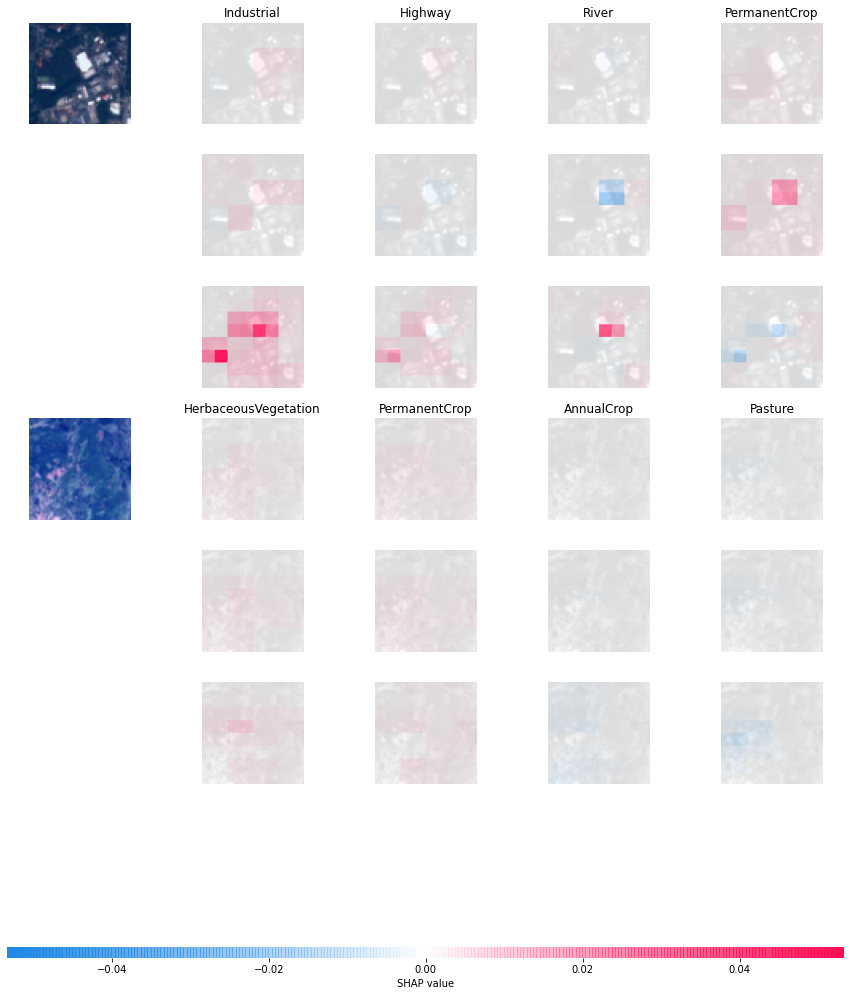

In [65]:
# Masker: 100x100 blur kernel
shap_values = explain_multiband(masker_blur_100x100)
save_shap(shap_values, "shap_eurosat_rgb_multiband_blur-100x100.npz")

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [00:33, 11.26s/it]


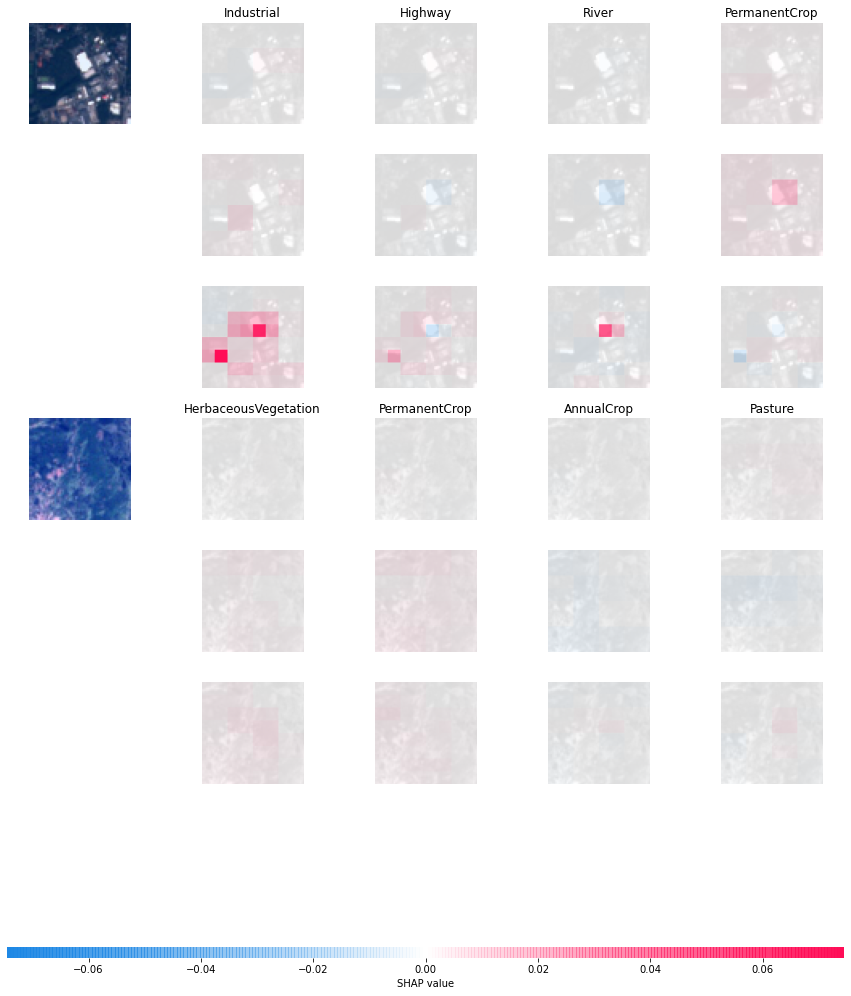

In [66]:
# Masker: black image
shap_values = explain_multiband(masker_uniform_black)
save_shap(shap_values, "shap_eurosat_rgb_multiband_uniform-black.npz")

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [00:33, 11.22s/it]


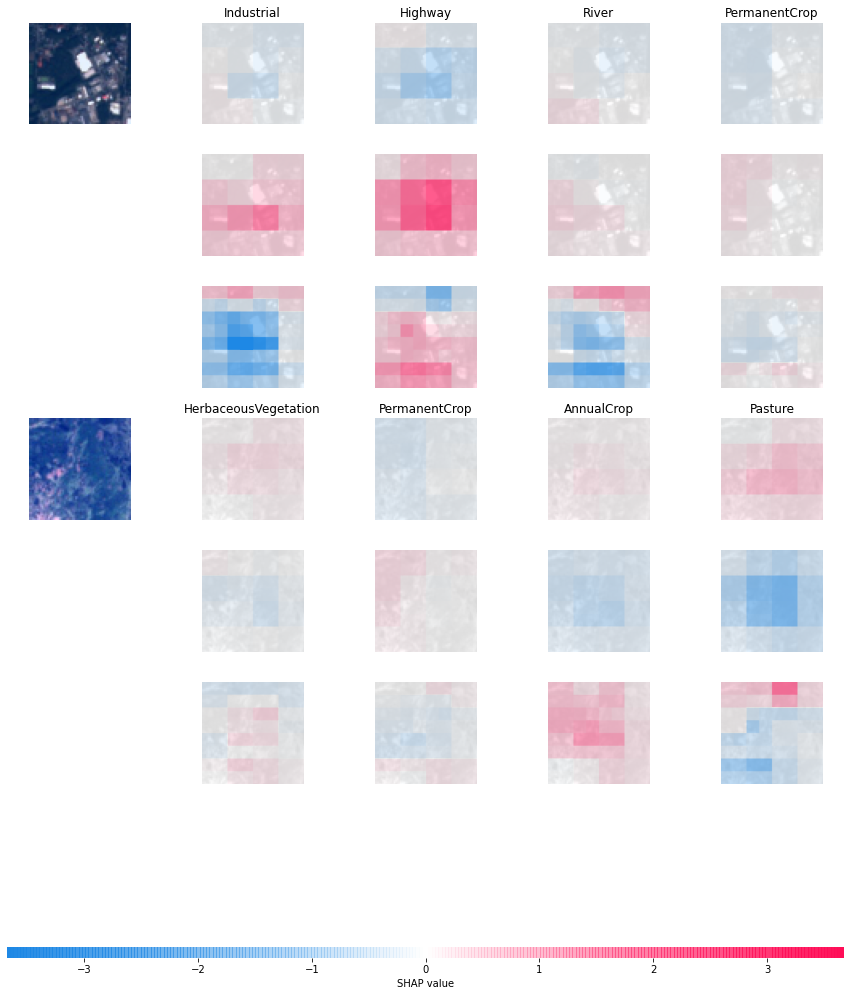

In [67]:
# Masker: gray image
shap_values = explain_multiband(masker_uniform_gray)
save_shap(shap_values, "shap_eurosat_rgb_multiband_uniform-gray.npz")

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [00:33, 11.08s/it]


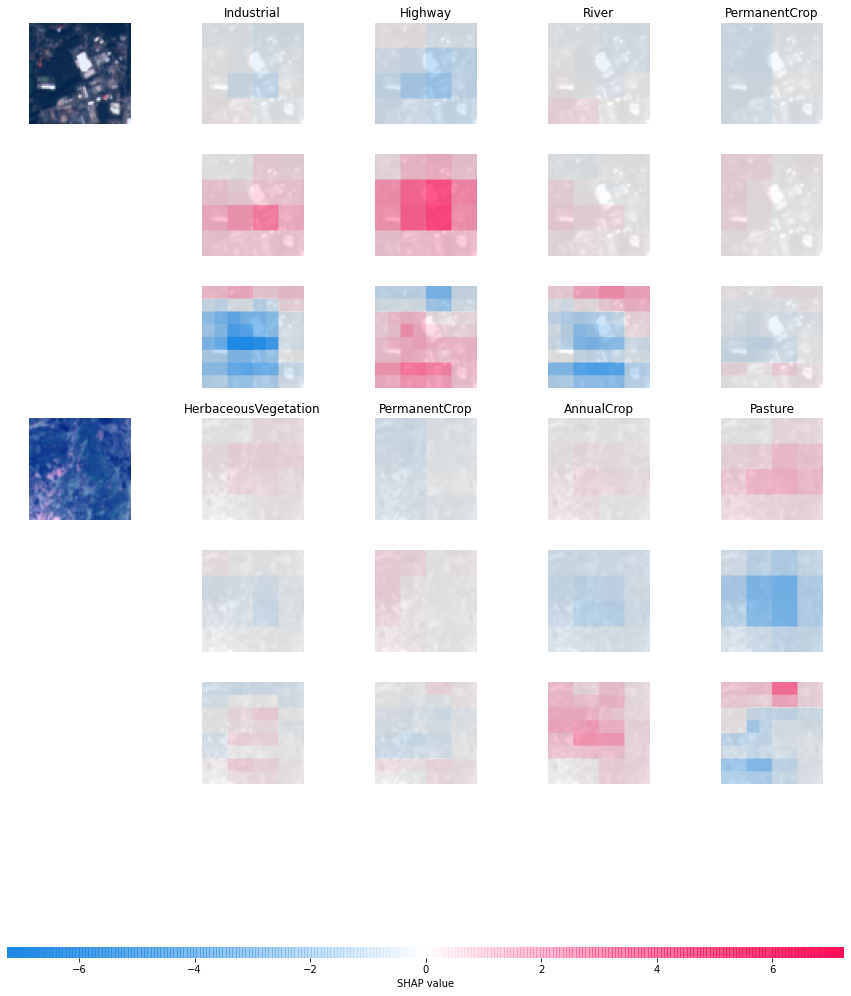

In [68]:
# Masker: white image
shap_values = explain_multiband(masker_uniform_white)
save_shap(shap_values, "shap_eurosat_rgb_multiband_uniform-white.npz")